## 1. 네오플 API에서 데이터 불러오기 및 저장

In [14]:
import sys
import requests
from urllib import parse
import datetime
import time
import pandas as pd
from matplotlib import rcParams

sys.stdin = open('../dnf_api_key.txt', 'r') # api key는 별도 파일로 저장

api_key = sys.stdin.readline().strip()

gateway = f"https://api.neople.co.kr/df/"

MyCharacters = ['回歸', '군생활80퍼', '안경자유로', '다시키워용', '싱크마스터', 'KK보벳따우', 
               '뭔활쟁이여', '回歸.', '작명이어려움', '흐아어으어', '사령키우기', '열열다섯', '배미딱',
               '추억의런치', '관짝에들어간', '눈에붕대', '새벽네시야', '나폴리갓바니', '돚거돚돚거', '십오오오',
               '퇴마를키우자', '스시스시스시']

# 캐릭터 기본 정보 검색
def search_info(character_id):
    return gateway + f"servers/cain/characters/{character_id}?apikey={api_key}"

def search_status(character_id):
    return gateway + f"servers/cain/characters/{character_id}/status?apikey={api_key}"

def search_timeline(character_id):
    """
    오늘부터 90일 전까지
    """
    end = datetime.datetime.now()
    start = end - datetime.timedelta(days=90)
    end = end.strftime('%Y-%m-%d %H:%M')
    start = start.strftime('%Y-%m-%d %H:%M')
    return gateway + f"servers/cain/characters/{character_id}/timeline?startDate={start}&endDate={end}&code=401,402,403,404,405,406,505,511,513,519,520,521,601,602&apikey={api_key}"

chr_lst = []

for i in range(len(MyCharacters)):
    
    # 캐릭터 검색 -> 캐릭터 id 얻기
    characterName = parse.quote(MyCharacters[i]) # URL 인코딩
    character = f"servers/cain/characters?characterName={characterName}&apikey={api_key}"
    url = gateway + character
    r = requests.get(url)
    chr_id = r.json()['rows'][0]['characterId']
    
    dct = {}
    dct['characterId'] = chr_id
    
    # 캐릭터 id로 명성 얻기
    url = search_status(chr_id)
    r = requests.get(url)
    reputation_dict = r.json()['status'][16]
    dct['reputation'] = reputation_dict['value'] if reputation_dict['name'] == '모험가 명성' else 0
    
    # 캐릭터 id로 마지막 아이템 습득 로그 시간 얻기
    url2 = search_timeline(chr_id)
    r2 = requests.get(url2)
    if r2.json()['timeline']['rows']:
        
        last_get_item = r2.json()['timeline']['rows'][0]['date']
        dct['last_access'] = last_get_item
        
    else:
        dct['last_access'] = (datetime.datetime.now() - datetime.timedelta(days=90)).strftime('%Y-%m-%d %H:%M')

    chr_lst.append(dct)
    time.sleep(0.3)

In [15]:
df = pd.DataFrame(chr_lst)

# df['last_access'] = df['last_access'].astype('datetime64')
df['last_access'] = pd.to_datetime(df['last_access'])

# 과거의 가장 가까운 2번째 목요일 구하기
today_weekday = datetime.datetime.now().weekday()
if today_weekday < 3:
    today_weekday + 7
x = -(today_weekday - 3) - 7

base_date = datetime.datetime.now() + datetime.timedelta(days = x)
base_date = base_date.replace(hour = 6, minute = 0, second = 0, microsecond = 0)
print(base_date)
df['is_playing'] = df['last_access'].apply(lambda x : True if x >= base_date else False)


# 명성 별 입장 가능 던전 정의
def dungeon(x: int):
    if x < 12656:
        return '노말 던전'
    elif x < 16052:
        return '더스크 노말'
    elif x < 17612:
        return '더스크 익스'
    elif x < 24472:
        return '파죽성 노말'
    elif x < 26230:
        return '파죽성 익스'
    elif x < 26933:
        return '더스크 마스터'
    elif x < 30267:
        return '마이스터 노말'
    elif x < 31795:
        return '파죽성 마스터'
    elif x < 33043:
        return '마이스터 익스'
    elif x < 34308:
        return '이스핀즈'
    elif x < 38095:
        return '개전'
    elif x < 40047:
        return '차원회랑'
    else:
        return '바칼 레이드'
    
df['dungeon'] = df['reputation'].apply(lambda x : dungeon(x))
dungeon_order = pd.CategoricalDtype(['노말 던전', '더스크 노말', '더스크 익스', '파죽성 노말', '파죽성 익스',
                                    '더스크 마스터', '마이스터 노말', '파죽성 마스터', '마이스터 익스', '이스핀즈',
                                    '개전', '차원회랑', '바칼 레이드'], ordered = True
                                   )
df['dungeon'] = df['dungeon'].astype(dungeon_order)
df.to_csv('my_characters.csv', index = False)

2023-04-06 06:00:00


## 2. 데이터 불러오기 및 시각화

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumGothic')

# csv 불러오기 및 시각화
df = pd.read_csv('my_characters.csv')
print(df.head())

# 수동으로 sort한 경우, category가 보존이 안된다
dungeon_order = pd.CategoricalDtype(['노말 던전', '더스크 노말', '더스크 익스', '파죽성 노말', '파죽성 익스',
                                    '더스크 마스터', '마이스터 노말', '파죽성 마스터', '마이스터 익스', '이스핀즈',
                                    '개전', '차원회랑', '바칼 레이드'], ordered = True
                                   )
df['dungeon'] = df['dungeon'].astype(dungeon_order)

                        characterId  reputation          last_access  \
0  4787c82dd563af3a1e2f833ba575f1f6       30661  2023-03-24 01:02:00   
1  6347bb2fc1c01c75cc014bc719ed7125       19250  2023-03-19 02:30:00   
2  9954bf01b357ebfd3e0983693a9a10b2       16929  2023-03-19 02:33:00   
3  652f7cae62053dc6ce9c98bdd7cac030       18225  2023-03-19 02:34:00   
4  7396c123cb5919f168c34096b46b3aa2       19522  2023-03-19 02:37:00   

   is_playing  dungeon  
0       False  파죽성 마스터  
1       False   파죽성 노말  
2       False   더스크 익스  
3       False   파죽성 노말  
4       False   파죽성 노말  


In [17]:
# 시각화
data = df['dungeon'].value_counts().to_frame().reset_index()

In [18]:
# 0값 표시하게 만들기
playing = pd.CategoricalDtype([True, False], ordered = True)
df['is_playing'] = df['is_playing'].astype(playing)
is_playing = df['is_playing'].value_counts(dropna = False).to_frame().reset_index()
is_playing

,index,is_playing
0,False,22
1,True,0


No handles with labels found to put in legend.


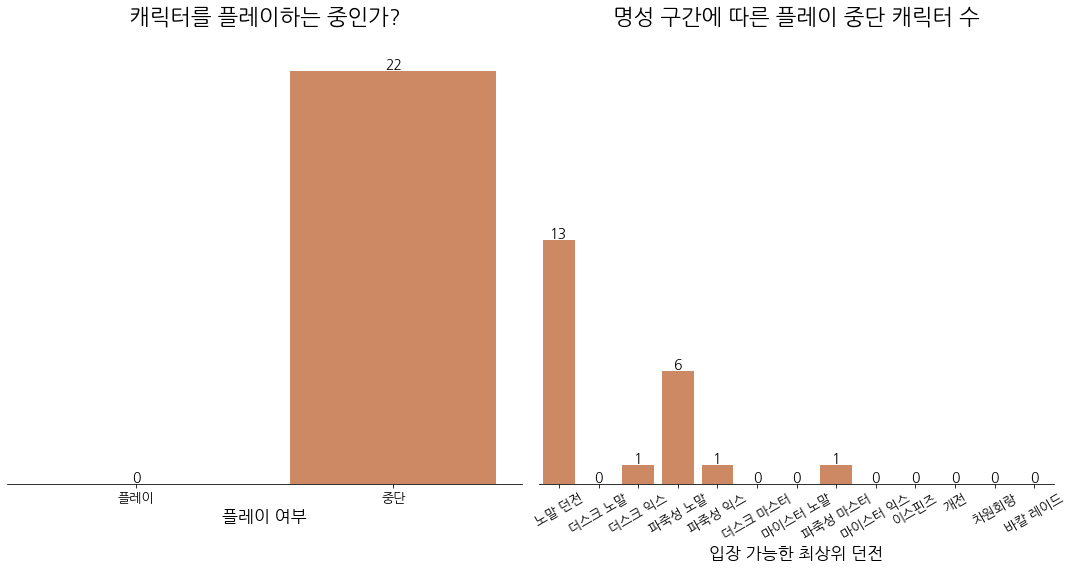

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8), sharey = True)
rcParams.update({'figure.autolayout': True})

ax_title_fontsize = 22
ax_title_y = 1.05
ax_label_fontsize = 17
ax_ticklabel_fontsize = 13
barlabel_fontsize = 14


# 1. 플레이 중인 캐릭터 표시
sns.barplot(data = is_playing, x = 'index', y = 'is_playing', ax = ax[0], palette = 'deep')
ax[0].bar_label(ax[0].containers[0], fontsize = barlabel_fontsize)
ax[0].axes.yaxis.set_visible(False)
ax[0].set_title('캐릭터를 플레이하는 중인가?', 
                fontsize = ax_title_fontsize, 
                y = ax_title_y)
ax[0].set_xlabel('플레이 여부', 
                 fontsize = ax_label_fontsize)
ax[0].set_xticklabels(['플레이', '중단'], 
                      fontsize = ax_ticklabel_fontsize)
ax[0].grid(True, axis = 'y', color = 'white')

# 2. 플레이하지 않는 캐릭터의 명성 구간
data = df[df['is_playing'] == False]['dungeon'].value_counts().to_frame().reset_index()

sns.barplot(data = data,
           x = 'index',
           y = 'dungeon',
           ax = ax[1],
            color = sns.color_palette('deep')[1])

ax[1].bar_label(ax[1].containers[0], 
                fontsize = barlabel_fontsize)
ax[1].set_title('명성 구간에 따른 플레이 중단 캐릭터 수', 
                fontsize = ax_title_fontsize, 
                y=ax_title_y)
sns.despine(left = True)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_xlabel('입장 가능한 최상위 던전',
                 fontsize = ax_label_fontsize,
                y= 1.5)
ax[1].set_xticklabels(ax[1].get_xticklabels(), 
                      rotation = 30, 
                      fontsize = ax_ticklabel_fontsize)
ax[1].legend().set_visible(False)
ax[1].grid(True, axis = 'y')


fig.tight_layout() # 그래프 저장 시 잘리는 현상 개선

fig.savefig('result.png', pad_inches = 0)

<Figure size 432x288 with 0 Axes>